(reglin_2_notebook)=
# Regressione lineare bivariata

In questo capitolo verrà discusso il modello di regressione bivariata, ovvero il modello che, mediante una relazione lineare, predice una variabile continua $y$ a partire da un solo predittore continuo $x$. Ciò corrisponde ad adattare ai dati ($x_i, y_i$) la retta di regressione $y_i = a + bx_i + e_i$, con $i=1, \dots, n$. Usando dei dati reali, vedremo come stimare i coefficienti di regressione $a$ e $b$, e come essi possono essere interpretati. Vedremo anche come descrivere la bontà di adattamento del modello ai dati.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import statistics
import statsmodels.api as sm
from scipy import optimize
from scipy.constants import golden
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")


In [6]:
%matplotlib inline
sns.set_theme(
    context="paper",
    style="darkgrid",
    palette="colorblind",
    rc={"figure.figsize": (5.0, 5.0 / golden)},
)

SEED = 12345
rng = np.random.default_rng(SEED)

Nell'esempio che discuteremo verranno usati i dati `kidiq` {cite}`gelman2020regression`:

> Data from a survey of adult American women and their children (a subsample from the National Longitudinal Survey of Youth).

-   kid_score Child's IQ score
-   mom_hs Indicator for whether the mother has a high school degree
-   mom_iq Mother's IQ score
-   mom_age Mother's age

Esamineremo la relazione tra l'intelligenza del bambino (`kid_score`) e l'intelligenza della madre (`mom_iq`). Ci chiederemo se, e in che misura, l'intelligenza della madre sia in grado di predire l'intelligenza del bambino. Per iniziare, leggiamo i dati.

In [7]:
kidiq = pd.read_stata("data/kidiq.dta")
kidiq.head()


,kid_score,mom_hs,mom_iq,mom_work,mom_age
0,65,1.0,121.117529,4,27
1,98,1.0,89.361882,4,25
2,85,1.0,115.443165,4,27
3,83,1.0,99.449639,3,25
4,115,1.0,92.745710,4,27


Un diagramma a dispersione per i dati di questo campione suggerisce la presenza di un'associazione positiva tra l'intelligenza del bambino (`kid_score`) e l'intelligenza della madre (`mom_iq`).

Text(0, 0.5, 'QI del bambino')

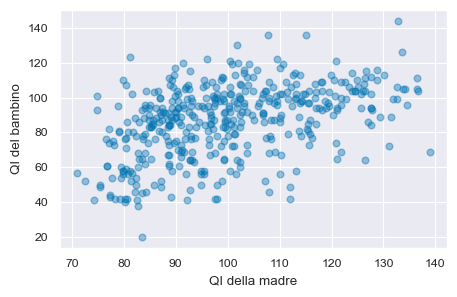

In [8]:
_, ax = plt.subplots()
ax.plot(kidiq["mom_iq"], kidiq["kid_score"], "o", alpha=0.4)
ax.set_xlabel("QI della madre")
ax.set_ylabel("QI del bambino")


Il modello di regressione lineare descrive questa associazione mediante una retta.

Text(0, 0.5, 'QI del bambino')

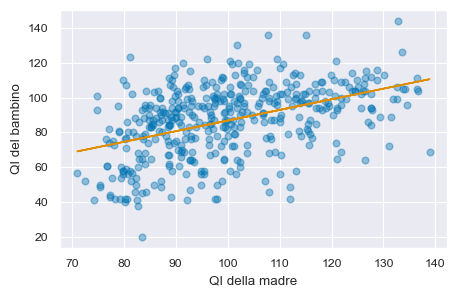

In [9]:
_, ax = plt.subplots()
ax.plot(kidiq["mom_iq"], kidiq["kid_score"], "o", alpha=0.4)
# obtain m (slope) and b(intercept) of linear regression line
b, a = np.polyfit(kidiq["mom_iq"], kidiq["kid_score"], 1)
# add linear regression line to scatterplot
plt.plot(kidiq["mom_iq"], a + b * kidiq["mom_iq"])
ax.set_xlabel("QI della madre")
ax.set_ylabel("QI del bambino")


Ci sono però infinite rette che, in linea di principio, possono essere usate per "approssimare" la nube di punti nel diagramma a dispersione. È dunque necessario introdurre dei vincoli per selezionare una di queste possibili rette. Il vincolo che viene introdotto dal modello di regressione è quello di costringere la retta a passare per il punto $(\bar{x}, \bar{y})$.

Text(0, 0.5, 'QI del bambino')

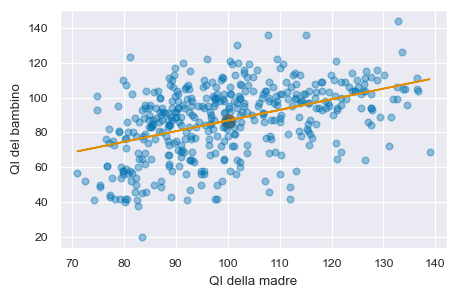

In [10]:
_, ax = plt.subplots()
ax.plot(kidiq["mom_iq"], kidiq["kid_score"], "o", alpha=0.4)
# obtain m (slope) and b(intercept) of linear regression line
b, a = np.polyfit(kidiq["mom_iq"], kidiq["kid_score"], 1)
# add linear regression line to scatterplot
plt.plot(kidiq["mom_iq"], a + b * kidiq["mom_iq"])
plt.scatter([np.mean(kidiq.mom_iq)], [np.mean(kidiq.kid_score)], s=90, c="r")
ax.set_xlabel("QI della madre")
ax.set_ylabel("QI del bambino")


Una retta che passa per il punto $(\bar{x}, \bar{y})$ (evidenziato in rosso nella figura precedente) ha delle desiderabili proprietà statistiche che verranno descritte in seguito.

Il campione è costituito da $n$ coppie di osservazioni ($x, y$). Per ciascuna coppia di valori $x_i, y_i$, il modello di regressione si aspetta che il valore $y_i$ sia associato al corrispondente valore $x_i$ come indicato dalla seguente equazione:

\begin{equation}
y_i = a + b x_i + e_i.
\end{equation}

I valori $y_i$ corrispondono, nell'esempio che stiamo discutendo, alla variabile `kid_score`. I primi 10 valori della variabile $y$ sono i seguenti:

In [11]:
kidiq["kid_score"][0:10]


0     65
1     98
2     85
3     83
4    115
5     98
6     69
7    106
8    102
9     95
Name: kid_score, dtype: int32

Per fare riferimento a ciascuna osservazione usiamo l'indice $i$. Quindi, ad esempio, $y_3$ è uguale a

In [12]:
print(kidiq["kid_score"][2])


85


Il modello di regressione bivariata, descritto dall'equazione precedente, ci dice che ciascun valore $y$ è dato dalla somma di due componenti: una componente deterministica e una componente aleatoria. Consideriamo il primo valore $y$ del campione. Per esso, il modello di regressione diventa

$$
y_1 = a + b x_1 + e_1,
$$

laddove $a + b x_1$ è la componente deterministica, denotata con $\hat{y}$, e $e_1$ è la componente aleatoria.

La componente deterministica è la *componente* di ciascun valore $y_i$ che è possibile prevedere conoscendo $x_i$. Tuttavia, non è possibile prevedere *perfettamente* i valori $y$ -- ciò si verificherebbe soltanto se tutti punti del diagramma a dispersione fossero disposti su una retta. Ma non lo sono mai nella pratica concreta: la retta è solo un'approssimazione della relazione lineare tra $x$ e $y$. Pertanto, conoscendo $x_i$ possiamo solo prevedere una porzione (o "componente") del corrispondente valore $y_i$.

Cosa significa che possiamo prevedere solo una componente di ciascuna osservazione $y_i$? Significa che il valore osservato $y_i$ sarà diverso dal valore $\hat{y}_i$ previsto dal modello. Ciascun valore osservato $y_i$ sarà dunque dato dalla seguente somma: $y_i = \hat{y}_i + e_i$, laddove $e_i$, detto "residuo" è la componente di $y_i$ non predicibile dal modello lineare.

Ci possiamo dunque porre due domande:

-   come è possibile trovare i coefficienti $a$ e $b$ che consentono di predire una componente della $y$ conoscendo la $x$?
-   quant'è grande la porzione della $y$ che può essere predetta conoscendo $x$? In altre parole, quant'è accurata la predizione della $y$ fornita dal modello di regressione lineare?

Rispondere a tali due domanda definisce i primi due obiettivi del modello statistico della regressione lineare. Il terzo obiettivo è quello dell'inferenza, ovvero quello di capire che relazioni ci sono tra la relazione tra $x$ e $y$ osservata nel campione e la la relazione tra le due variabili nella popolazione.

## Stima dei coefficienti di regressione

Iniziamo con il primo obiettivo, ovvero quello di trovare i coefficienti $a$ e $b$ che consentono di predire una componente di ciascuna osservazione $y$ conoscendo $x$. Quindi, nel caso presente, ci chiediamo quanto segue. Il primo bambino del campione ha un QI uguale a 65. Sua madre ha un QI di 121.12. Qual è la predizione migliore del QI del bambino che possiamo ottenere conoscendo il QI della madre?

È chiaro, guardando i dati del campione, che non c'è una corrispondenza perfetta tra QI della madre e QI del bambino, tutt'altro! Infatti, se guardiamo il diagramma di dispersione ci rendiamo conto che i punti sono piuttosto lontani dalla retta che abbiamo sovrapposto alla nube di punti $x_i, y_i$. Tuttavia, il diagramma di dispersione ci suggerisce che, al di là del rumore, c'è comunque una relazione tra le due variabili. Il nostro obiettivo è trovare un metodo quantitativo per descrivere una tale relazione.

Abbiamo detto che è possibile prevedere una componente di $y_i$ conoscendo $x_i$. La componente $y_i$ predicibile da $x_i$ viene denotata da $\hat{y}_i$ e, nei termini del modello di regressione lineare è uguale a

$$
\hat{y}_i = a_i + bx_i.
$$

L'equazione precedente è un'*equazione lineare* e, dal punto di vista geometrico, corrisponde ad una retta. Ci sono infinite equazioni che, in linea di principio, possiamo usare per descrivere la relazione tra $x$ e $y$. Abbiamo scelto la relazione lineare perché è la più semplice. Se guardiamo il diagramma di dispersione, infatti, non ci sono ragioni per descrivere la relazione tra il QI del bambino e il QI della madre con qualche curva, anziché con una retta. In altri campioni, una curva potrebbe essere più sensata di una retta, quale descrizione della relazione *media* tra $x$ e $y$, ma non nel caso presente. Ricordiamo il principio del rasoio di Occam (ovvero, il principio che sta alla base del pensiero scientifico moderno): se un modello semplice funziona, non c'è ragione di usare un modello più complesso.

Dunque, abbiamo capito che vogliamo descrivere la *relazione media* tra $x$ e $y$ con una retta, ovvero, mediante l'equazione lineare

$$
\hat{y}_i = a + b x_i.
$$

L'equazione precedente ci dice che il modello lineare $a + b x_i$ *non è in grado di prevedere completamente* i valori $y_i$. Questo, in generale, non è mai possibile (ovvero, è possibile solo in un caso specifico che, nella realtà empirica, non si verifica mai). L'equazione precedente ci dice che possiamo prevedere solo una componente di ciascuna osservazione $y_i$, ovvero quella componente che abbiamo denotato con $\hat{y}_i$. La componente che non possiamo prevedere con l'equazione $a + b x_i$ viene detta *residuo* e si denota con $e_i$:

$$
e_i = y_i - \hat{y}_i = y_i - (a + bx_i).
$$

Dal punto di vista geometrico, la componente erratica del modello, $e_i$, corrisponde alla distanza verticale tra ciascun punto del diagramma a dispersione e la retta di regressione $a + bx$. La retta di regressione, dunque, scompone ciascuna $y_i$ in due componenti, ovvero

$$
y_i = \hat{y}_i + e_i = (a + bx_i) + e_i. 
$$

Il primo obiettivo del modello di regressione è quello di trovare i coefficienti dell'equazione

$$
 a + b x_i
 $$

che consente di trovare $\hat{y}_i$ conoscendo $x_i$. Questi due coefficienti sono detti *coefficienti di regressione*.

Per trovare i coefficienti di regressione dobbiamo introdurre dei vincoli per limitare lo spazio delle possibili soluzioni. Il primo di tali vincoli è stato introdotto in precedenza: vogliamo che la retta $\hat{y}_i = a + b x_i$ passi per il punto $(\bar{x}, \bar{y})$. Il punto $(\bar{x}, \bar{y})$ corrisponde al *baricentro* del diagramma a dispersione.

Ci sono però infinite rette che passano per i punto $(\bar{x}, \bar{y})$. Tutte queste rette soddisfano la seguente proprietà:

$$
\sum_{i=1}^n e_i = 0,
$$

ovvero, fanno in modo che la somma dei residui (positivi, per i punti che si trovano al di sopra della retta di regressione, negativi, per punti che si trovano al di sotto della retta di regressione) sia uguale a zero.

Questo significa che non possiamo selezionare una tra le infinite rette che passano per il punto $(\bar{x}, \bar{y})$ usando il criterio che ci porta a scegliere la retta che rende la più piccola possibile (ovvero, minimizza) la somma dei residui. Infatti, tutte le rette passanti per il punto $(\bar{x}, \bar{y})$ soddisfano questo requisito (rendono uguale a zero la somma dei residui). Dunque, dobbiamo trovare qualche altri criterio per scegliere una tra le infinite rette che passano per il punto $(\bar{x}, \bar{y})$.

Il criterio che viene normalmente scelto è quello di *minimizzare la somma dei quadrati dei residui* $(y_i - \hat{y}_i)^2$. In altri termini, vogliamo trovare i coefficienti $a$ e $b$ tali per cui la quantità

$$
\sum_{i=1}^{n}{(y_i - (a + b x_i))^2}
$$

assume il suo valore minimo. I coefficienti $a$ e $b$ che soddisfano questa proprietà si chiamano *coefficienti dei minimi quadrati*.

Questo problema ha una soluzione analitica. La soluzione analitica si trova riconoscendo il fatto che l'equazione precedente definisce una superficie e il problema diventa quello di trovare il punto di minimo di questa superficie. Il punto cercato è quello per cui il piano tangente alla superficie (nelle due direzioni $a$ e $b$) è piatto (le tangenti nelle due direzioni sono uguali a zero). Rendere uguale a zero la tangente ad una curva significa porre uguali a zero la derivata della curva. Nel caso presente, abbiamo una superficie, dunque due tangenti ortogonali e quindi dobbiamo rendere uguali a zero le derivate parziali rispetto ad $a$ e $b$. Così facendo si definisce un sistema di equazioni lineari con due incognite, $a$ e $b$. La soluzione di tali equazioni, che si chiamano *equazioni normali*, è la seguente:

$$
a = \bar{y} - b \bar{x},
$$

$$
b = \frac{Cov(x, y)}{Var(x)}.
$$

Le due precedenti equazioni corrispondono alla *stima dei minimi quadrati* dei coefficienti di regressione della retta che minimizza la somma dei quadrati dei residui.

Nel caso dell'esempio presente, tali coefficienti sono uguali a:

In [13]:
cov_xy = np.cov(kidiq["kid_score"], kidiq["mom_iq"], ddof=1)[0][1]
var_x = np.var(kidiq["mom_iq"], ddof=1)
b = cov_xy / var_x
b


0.609974571730785

In [14]:
a = np.mean(kidiq["kid_score"]) - b * np.mean(kidiq["mom_iq"])
a


25.799777849962986

Verifichiamo i risultati trovati usando funzione `optimize.curve_fit`. Questa è una funzione molto potente, in quanto può adattarsi non solo alle funzioni lineari, ma anche alle funzioni non lineari. Qui la usiamo per la retta di regressione.

In [16]:
def func(x, a, b):
    y = a + b*x
    return y
  
optimize.curve_fit(func, xdata = kidiq.mom_iq, ydata = kidiq.kid_score)[0]

array([25.7997779 ,  0.60997457])

In precedenza abbiamo soltanto accennato al problema di come si possono trovano i coefficienti dei minimi quadrati; ritorneremo su questo punto in seguito, con una simulazione. Per ora, chiediamoci cosa significano i due coefficienti che abbiamo appena trovato.

Il coefficiente $a$ si chiama *intercetta*. L'intercetta, all'interno del diagramma a dispersione, specifica il punto in cui la retta di regressione interseca l'asse $y$ del sistema di assi cartesiani.

Nel caso presente questo valore non è di alcun interesse, perché corrisponde al valore della retta di regressione quando $x = 0$, ovvero quando l'intelligenza della madre è uguale a 0. Vedremo in seguito come, trasformando i dati, è possibile assegnare al coefficiente $a$ un'interpretazione più utile. Per ora mi limito a fornire l'interpretazione del coefficiente.

Passando a $b$, possiamo dire che questo secondo coefficiente va sotto il nome di *pendenza* della retta di regressione. Ovvero ci dice di quanto aumenta (se $b$ è positivo) o diminuisce (se $b$ è negativo) la retta di regressione in corrispondenza di un aumento di 1 punto della variabile $x$.

Nel caso presente, il coefficiente $b$ ci dice che, se il QI delle madri aumenta di 1 punto, il QI dei bambini aumenta **in media** di 0.61 punti.

È importante capire cosa significa che, in base ai risultati della regressione, $y$ aumenta *in media* di $b$ punti per ciascun aumento unitario di $x$.

Il modello statistico di regressione *ipotizza* che, per ciascun valore osservato $x$ (per esempio, il valore del QI della prima madre del campione, ovvero $x = 121.11753$) ci sia una distribuzione di valori $y$ nella popolazione, di cui solo uno è stato osservato nel campione. Possiamo facilmente capire che, se consideriamo tutte le madri con QI di 121.12, il punteggio del QI dei loro figli non sia costante, ma assuma tanti valori possibili. Questa distribuzione di valori possibili si chiama distribuzione $y$ condizionata a $x$, ovvero $p(y \mid x_i)$.

Il modello statistico della regressione lineare non può in alcun modo prevedere il valore assunto da ciascuna delle possibili osservazioni che fanno parte della distribuzione $p(y \mid x_i)$. Il modello della regressione lineare ha un obiettivo più limitato, ovvero si propone di prevedere *le medie* delle distribuzioni $p(y \mid x_i)$ conoscendo i valori $x$.

Dunque, quando il coefficiente $b$ è uguale a 0.61, questo significa che il modello di regressione predice che *la medie* della distribuzione condizionata $p(y \mid x_i)$ aumenta di 0.61 punti se la variabile $x$ (QI delle madri) aumenta di un punto. Questo significa che il modello di regressione non fa una predizione sul punteggio di ciascun valore $y_i$ (in funzione di $x$), ma solo della media delle distribuzioni condizionate $p(y \mid x_i)$ di cui il valore osservato $y_i$ è una realizzazione casuale.

Possiamo dire la stessa cosa con parole diverse dicendo che il modello di regressione fa delle predizioni sulla componente deterministica di ciascuna osservazione. È più semplice capire questo aspetto se rappresentiamo in maniera grafica la componente "deterministica" $\hat{y}_i = a + b x_i$ predetta dal modello di regressione.

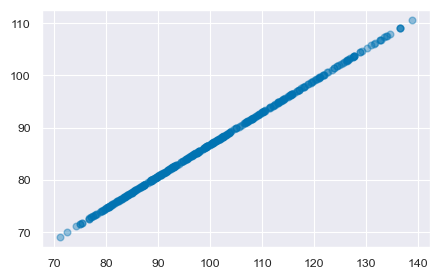

In [17]:
_, ax = plt.subplots()
ax.plot(kidiq["mom_iq"], a + b * kidiq["mom_iq"], "o", alpha=0.4)


Il diagramma precedente presenta ciascun valore $\hat{y}_i = a + b x_i$ in funzione di $x_i$. Si vede che i valori predetti dal modello di regressione sono i punti che stanno sulla retta di regressione.

In precedenza abbiamo detto che il residuo, ovvero la componente di ciascuna osservazione $y_i$ che non viene predetta dal modello di regressione, corrisponde alla *distanza verticale* tra il valore $y_i$ osservato e il valore $\hat{y}_i$ predetto dal modello di regressione:

$$
e_i = y_i - (a + b x_i).
$$

Nel caso nella prima osservazione, ad esempio abbiamo:

$$
y_1 = (a + b x_1) + e_1
$$

Consideriamo il punteggio osservato del QI del primo bambino.

In [18]:
print(kidiq["kid_score"][0])


65


Per questo punteggio, il valore predetto dal modello di regressione è

In [19]:
a + b * kidiq["mom_iq"][0]


99.67839048842711

Per questa osservazione, il residuo (ovvero, l'errore che compiamo utilizzando il modello di regression per predire il QI del bambino) è

In [20]:
kidiq["kid_score"][0] - (a + b * kidiq["mom_iq"][0])


-34.67839048842711

Per tutte le osservazioni abbiamo

In [21]:
res = kidiq["kid_score"] - (a + b * kidiq["mom_iq"])
res


0     -34.678390
1      17.691747
2     -11.217173
3      -3.461529
4      32.627697
         ...    
429    16.427159
430    -6.521552
431   -33.661788
432     3.120144
433   -11.461993
Length: 434, dtype: float64

È una proprietà del modello di regressione (calcolato con il metodo dei minimi quadrati) che la somma dei residui sia uguale a zero.

In [22]:
np.sum(res)


-3.183231456205249e-12

Ciò significa che ciascuno dei valore osservato $y_i$ viene scomposto dal modello di regressione in due componenti. La componente deterministica $\hat{y}_i$, predicibile da $x_i$, è $\hat{y}_i = a + b x_i$. Il residuo è $e_i = y_i - \hat{y}_i$. La somma della componente deterministica e della componente erratica, ovviamente, riproduce il valore osservato.

### Trasformazione dei dati

In generale, per variabili a livello di scala ad intervalli, non è possibile assegnare un'interpretazione utile all'intercetta del modello di regressione lineare. L'intercetta ci dice infatti qual è il valore atteso della $y$ quando $x = 0$. Ma, se la variabile $x$ è misurata su scala ad intervalli, il valore $x = 0$ è arbitrario e non corrisponde "all'assenza di intensità" della variabile $x$. Un valore pari a 0 del QI della madre non vuol dire che l'intelligenza della madre sia nulla (un'affermazione, questa, che è difficile da capire), ma semplicemente che il punteggio del test usato per misurare il QI della madre assume valore 0 (qualcosa che, comunque, in pratica non succederà mai). Quindi è di poco interesse sapere qual è il valore medio del QI del bambino quando test usato per misurare il QI della madre ha valore 0. Per potere fornire all'intercetta del modello di regressione un'interpretazione più utile dobbiamo trasformare le osservazioni $x$.

Esprimiamo $x$ come differenza dalla media. Chiamiamo questa nuova variabile $xd$:

In [23]:
kidiq["xd"] = kidiq["mom_iq"] - np.mean(kidiq["mom_iq"])
kidiq


,kid_score,mom_hs,mom_iq,mom_work,mom_age,xd
0,65,1.0,121.117529,4,27,21.117529
1,98,1.0,89.361882,4,25,-10.638118
2,85,1.0,115.443165,4,27,15.443165
3,83,1.0,99.449639,3,25,-0.550361
4,115,1.0,92.745710,4,27,-7.254290
...,...,...,...,...,...,...
429,94,0.0,84.877412,4,21,-15.122588
430,76,1.0,92.990392,4,23,-7.009608
431,50,0.0,94.859708,2,24,-5.140292
432,88,1.0,96.856624,2,21,-3.143376


Se ora usiamo le coppie di osservazioni $(xd_i, y_i)$, il diagramma a dispersione assume la forma seguente.

Text(0, 0.5, 'QI del bambino')

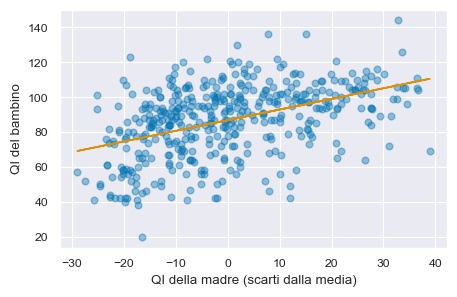

In [24]:
_, ax = plt.subplots()
ax.plot(kidiq["xd"], kidiq["kid_score"], "o", alpha=0.4)
b, a = np.polyfit(kidiq["xd"], kidiq["kid_score"], 1)
plt.plot(kidiq["xd"], a + b * kidiq["xd"])
ax.set_xlabel("QI della madre (scarti dalla media)")
ax.set_ylabel("QI del bambino")


Quello che abbiamo fatto è stato di *traslare rigidamente* la nube di punti sul piano cartesiano di una quantità pari alla distanza tra $\bar{x}$ e l'origine. Dunque, le *relazioni spaziali* tra i punti del diagramma a dispersione restano immutate. Di conseguenza, la pendenza della retta di regressione calcolata sui dati trasformati è uguale a quella che si trova nel caso dei dati non trasformati. Ciò che cambia è solo il valore dell'intercetta.

In [25]:
result = stats.linregress(kidiq.xd, kidiq.kid_score)
result.intercept, result.slope


(86.79723502304148, 0.6099745717307852)

L'intercetta corrisponde al punto sull'asse $y$ dove la retta di regressione interseca l'ordinata. Ma, nel caso dei dati trasformati, dato che abbiamo traslato i punti di una quantità pari a $x - \bar{x}$, il valore $xd = 0$ corrisponde a $x = \bar{x}$ nel caso dei dati grezzi. Dunque, per i dati trasformati $xd_i, y_i$, l'intercetta corrisponderà al valore atteso della $y$ in corrispondenza del valore medio della variabile $x$ sulla scala dei dati non trasformati (ovvero $\bar{x}$). In altre parole, l'intercetta del modello di regressione lineare calcolata sui dati trasformati corrisponde al QI medio dei bambini in corrispondenza del QI medio delle madri.

### Il metodo dei minimi quadrati

Ora che abbiamo visto come interpretare il coefficienti di regressione, chiediamoci come vengono calcolati. La procedura generale è stata brevemente descritta in precedenza. Vediamo ora come si giunge alla conclusione descritta sopra usando una simulazione.

Il problema è di trovare i valori $a$ e $b$ tali per cui la quantità $\sum_{i=1}^{n}{(y_i - (a + b x_i))^2}$ assume il valore minore possibile. Questo è un problema di minimizzazione rispetto a due parametri. Per dare un'idea di come si fa, semplifichiamo il problema e supponiamo che uno dei due parametri sia noto, ad esempio $a$, così ci resta una sola incognita.

Credo una griglia di valori `b_grid` possibili, ad esempio:

In [26]:
b_grid = np.linspace(0, 1, 1001)


Definisco una funzione che calcola la quantità $\sum_{i=1}^{n}{(y_i - (a + b x_i))^2}$:

In [27]:
def sse(a, b, x, y):
    return np.sum((y - (a + b * x)) ** 2)


Calcolo la somma degli errori quadratici per ciascun possibile valore `b_grid`, fissando $a = 25.79978$.

In [28]:
a = 25.79978
sse_vals = [sse(a, b, kidiq["mom_iq"], kidiq["kid_score"]) for b in b_grid]


Esaminiamo il risultato ottenuto.


Text(0, 0.5, 'SSE')

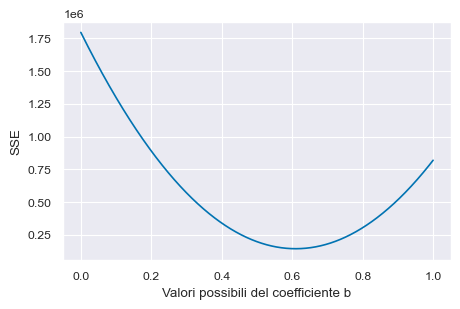

In [29]:
_, ax = plt.subplots()
ax.plot(b_grid, sse_vals)
ax.set_xlabel("Valori possibili del coefficiente b")
ax.set_ylabel("SSE")


Il risultato ottenuto con la simulazione riproduce quello ottenuto per via analitica.


In [30]:
df = pd.DataFrame({"x": b_grid, "y": sse_vals})
df


,x,y
0,0.000,1.795165e+06
1,0.001,1.789756e+06
2,0.002,1.784356e+06
3,0.003,1.778965e+06
4,0.004,1.773583e+06
...,...,...
996,0.996,8.053831e+05
997,0.997,8.088135e+05
998,0.998,8.122527e+05
999,0.999,8.157008e+05


In [31]:
df[df.y == df.y.min()]


,x,y
610,0.61,144137.339359


Una simulazione simile, ma computazionalmente più complessa, può essere usata per stimare simultaneamente entrambi i coefficienti del modello lineare. Ci siamo limitati qui ad una *proof of concept* del caso più semplice.

### L'errore standard della regressione

Il secondo obiettivo del modello statistico di regressione lineare è quello di stabilire *quanto sia grande la componente* $y$ predicibile da $x$, per ciascuna osservazione. Un indice assoluto della bontà di adattamento è fornito dalla deviazione standard dei residui, $s_e$, chiamata anche *errore standard della stima*. Uno stimatore non distorto della varianza dei residui nella popolazione è dato da

$$
s^2_e = \frac{1}{n-2}\sum e_i^2
$$

e quindi l'errore standard della stima sarà

$$
s_e = \sqrt{\frac{1}{n-2}\sum e_i^2}.
$$

Si noti che questa è la stessa formula della varianza (dato che la media dei residui è zero), tranne per il fatto che al denominatore abbiamo $n-2$. Dato che, per calcolare $\hat{y}$ abbiamo usato due coefficienti ($a$ e $b$), si dice che "abbiamo perso due gradi di libertà".

Dato che $s_e$ possiede la stessa unità di misura della variabile $y$, l'errore standard della stima può essere considerato come una sorta di "residuo medio." -- usando la stessa interpretazione che diamo alla deviazione standard in generale. Si noti che la formula precedente non fornisce la "deviazione standard dei residui nel campione" (quella formula avrebbe $n$ al denominatore). Invece, fornisce una *stima* della deviazione standard dei residui nella popolazione da cui il campione è stato estratto.

Verifichiamo quanto detto con i dati a disposizione. I residui possono essere trovati nel modo seguente.

In [32]:
e = kidiq.kid_score - (a + b * kidiq.mom_iq)
e[1:10]


1    17.691744
2   -11.217175
3    -3.461531
4    32.627695
5     6.382843
6   -41.521043
7     3.864879
8    26.414384
9    11.208066
dtype: float64

Calcolo il residuo medio, prendendo il valore assoluto.


In [98]:
np.mean(np.abs(e))


14.46860267547228

L'errore standard della regressione è


In [33]:
np.sqrt(sum(e**2) / (len(e) - 2))


18.2661227922994

I due numeri non sono uguali, ma hanno lo stesso ordine di grandezza.

## Indice di determinazione

Un importante risultato dei minimi quadrati riguarda la cosiddetta *scomposizione della devianza* mediante la quale si definisce l'indice di determinazione, il quale fornisce una misura relativa della bontà di adattamento del modello di regressione ai dati del campione. Per una generica osservazione $x_i, y_i$, la variazione di $y_i$ rispetto alla media $\bar{y}$ può essere descritta come la somma di due componenti: il residuo $e_i=y_i- \hat{y}_i$ e lo scarto di $\hat{y}_i$ rispetto alla media $\bar{y}$:

$$
y_i - \bar{y} = (y_i- \hat{y}_i) + (\hat{y}_i - \bar{y}) = e_i + (\hat{y}_i - \bar{y}).
$$

Se consideriamo tutte le osservazioni, la devianza delle $y$ può essere scomposta nel seguente modo:

$$
\begin{align}
 \sum (y_i - \bar{y})^2 &= \sum \left[ e_i + (\hat{y}_i - \bar{y})
 \right]^2 
 = \sum e_i^2 + \sum (\hat{y}_i - \bar{y})^2 + 2 \sum e_i (\hat{y}_i -
 \bar{y}) \notag
\end{align}
$$

Per i vincoli imposti sul modello statistico di regressione, il doppio prodotto si annulla, infatti

$$
\begin{align}
\sum e_i (\hat{y}_i - \bar{y}) &= \sum e_i \hat{y}_i - \bar{y}\sum e_i = \sum e_i (a + b x_i) \notag \\
&= a \sum e_i + b \sum e_i x_i = 0 \notag
\end{align}
$$

Il termine $b \sum e_i x_i$ è uguale a zero perché, come vedremo in seguito, i coefficienti di regressione vengono calcolati in modo tale da rendere nulla $Cov(e, x)$. Di conseguenza, il termine precedente deve essere nullo.

Possiamo dunque concludere che la devianza totale ($dev_T$) si scompone nella somma di devianza d'errore (o devianza non spiegata) ($dev_E$) e devianza di regressione (o devianza spiegata) ($dev_T$):

$$
\begin{align}
\underbrace{\sum_{i=1}^n (y_i - \bar{y})^2}_{\tiny{\text{Devianza
totale}}} &= \underbrace{\sum_{i=1}^n e_i^2}_{\tiny{\text{Devianza
di dispersione}}} + \underbrace{\sum_{i=1}^n  (\hat{y}_i -
\bar{y})^2}_{\tiny{\text{Devianza di regressione}}} \notag
\end{align}
$$

La devianza di regressione, $dev_R = dev_T - dev_E$, indica dunque la riduzione degli errori al quadrato che è imputabile alla regressione lineare. Il rapporto $dev_R/dev_T$, detto *indice di determinazione*, esprime tale riduzione degli errori in termini proporzionali e definisce il coefficiente di correlazione al quadrato:

$$
R^2 = \frac{dev_R}{dev_T} = 1 - \frac{dev_E}{dev_T}.
$$

Quando l'insieme di tutte le deviazioni della $y$ dalla media è spiegato dall'insieme di tutte le deviazioni della variabile teorica $\hat{y}$ dalla media, si ha che l'adattamento (o accostamento) del modello al campione di dati è perfetto, la devianza residua è nulla ed $r^2 = 1$; nel caso opposto, la variabilità totale coincide con quella residua, per cui $r^2 = 0$. Tra questi due estremi, $r$ indica l'intensità della relazione lineare tra le due variabili e $r^2$, con $0 \leq r^2 \leq 1$, esprime la porzione della devianza totale della $y$ che è spiegata dalla regressione lineare sulla $x$.

Per l'esempio in discussione abbiamo quanto segue. La devianza totale è

In [34]:
dev_t = np.sum((kidiq.kid_score - np.mean(kidiq.kid_score)) ** 2)
dev_t


180386.15668202768

La devianza spiegata è

In [35]:
dev_r = np.sum(((a + b * kidiq.mom_iq) - np.mean(kidiq.kid_score)) ** 2)
dev_r


36248.820197060355

L'indice di determinazione è


In [36]:
R2 = dev_r / dev_t
round(R2, 3)


0.201

Verifichiamo.

In [37]:
X = sm.add_constant(kidiq["mom_iq"])
mod = sm.OLS(kidiq["kid_score"], X)
res = mod.fit()
res.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              kid_score   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     108.6
Date:                Sat, 04 Feb 2023   Prob (F-statistic):           7.66e-23
Time:                        08:05:17   Log-Likelihood:                -1875.6
No. Observations:                 434   AIC:                             3755.
Df Residuals:                     432   BIC:                             3763.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.7998      5.917      4.360      0.000      14.169      37.430
mom_iq         0.6100      0.059     10.423      0.000       0.495       0.725
==============================================================================
Omnibus:                        7.545   Durbin-Watson:                   1.645
Prob(Omnibus):                  0.023   Jarque-Bera (JB):                7.735
Skew:                          -0.324   Prob(JB):                       0.0209
Kurtosis:                       2.919   Cond. No.                         682.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Il risultato ottenuto si può interpretare dicendo che circa il 20% della variabilità dei punteggi del QI dei bambini può essere predetto conoscendo il QI delle madri.

### Inferenza sul modello di regressione

La discussione precedente era tutta basata sulla trattazione "classica" del modello lineare, ovvero una trattazione basata sulle stime di massima verosimiglianza (se $y \sim \mathcal{N}(\alpha + \beta x, \sigma)$, allora le stime dei minimi quadrati coincidono con le stime di massima verosimiglianza). In altre parole, nella discussione precedente non abbiamo considerato in alcun modo le distribuzioni a priori dei parametri $\alpha$ e $\beta$. I risultati precedenti si confermano, in un contesto bayesiano, se e solo se imponiamo sui parametri delle distribuzioni a priori non informative (cioè, uniformi). In tali circostanze, le stime di massima verosimiglianza risultano identiche al massimo a posteriori bayesiano.

Detto questo, il tema dell'inferenza viene trattato dall'approccio frequentista costruendo la "distribuzione campionaria" dei parametri (ovvero la distribuzione dei valori che i parametri otterrebbero in infiniti campioni casuali ($x, y$) di ampiezza $n$ estratti dalla medesima popolazione) e poi calcolando gli errori standard dei parametri e gli intervalli di fiducia dei parametri. Una domanda frequente è, per esempio, se la pendenza della retta di regressione sia maggiore di zero. Per rispondere a tale domanda l'approccio frequentista calcola l'intervallo di fiducia al 95% per il parametro $\beta$. Se tale intervallo non include lo zero, e se il limite inferiore di tale intervallo è maggiore di zero, allora si conclude, con un grado di confidenza del 95%, che il vero parametro $\beta$ nella popolazione è maggiore di zero. Ovvero, si conclude che vi sono evidenze di un'associazione lineare positiva tra $x$ e $y$.

Alla stessa conclusione si può arrivare calcolando, in un ottica bayesiana, l'intervallo di credibilità al 95% per il parametro $\beta$. I due intervalli sono identici se usiamo una distribuzione a priori piatta. Sono invece diversi se usiamo una distribuzione a priori debolmente informativa, oppure informativa.

Solitamente si usa una distribuzione a priori debolmente informativa centrata sullo zero. In tali circostanze, l'uso della distribuzione a priori ha solo un effetto di *regolarizzazione*, ovvero di riduzione del peso delle osservazioni estreme -- un tale risultato statistico è molto desiderabile, ma è difficile da ottenere in un contesto frequentista. Vedremo nel prossimo capitolo come può essere svolta l'inferenza sui coefficienti del modello di regressione lineare in un contesto bayesiano.

## Commenti e considerazioni finali

Il modello lineare bivariato viene usato per descrivere la relazione tra due variabili e per determinare il segno e l'intensità di tale relazione. Inoltre, il modello lineare ci consente di prevedere il valore della variabile dipendente in base al valore assunto dalla variabile indipendente.

## Watermark

In [104]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Mon Dec 26 2022

Python implementation: CPython
Python version       : 3.8.15
IPython version      : 8.7.0

pytensor: 2.8.10

debugpy    : 1.5.1
scipy      : 1.9.3
seaborn    : 0.12.1
arviz      : 0.14.0
sys        : 3.8.15 (default, Nov 24 2022, 09:04:07) 
[Clang 14.0.6 ]
numpy      : 1.24.0
pandas     : 1.5.2
statsmodels: 0.13.5
ipykernel  : 6.15.2
matplotlib : 3.6.2

Watermark: 2.3.1

